In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

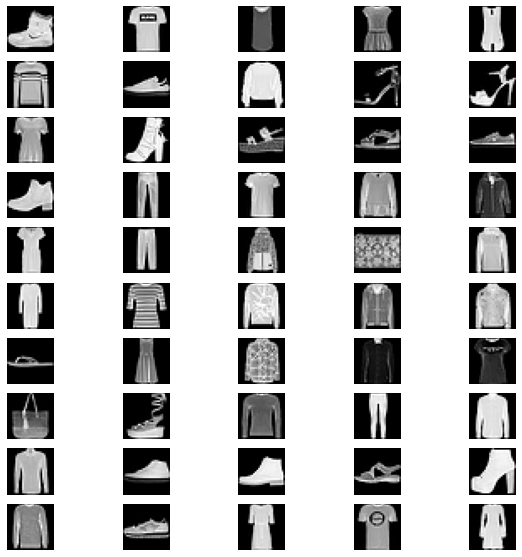

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(50):
  plt.subplot(10, 5, i+1)
  plt.axis('off')
  plt.imshow(x_train[i], cmap = 'gray')

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Embedding, Dropout, Reshape, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
def make_dic(input_dim = (28, 28, 1), n_classes = 10):
  imi = Input(shape = input_dim)

  lip = Input(shape = (1,))
  l = Embedding(n_classes, 50)(lip)
  l = Dense(input_dim[0]*input_dim[1])(l)
  l = Reshape((input_dim[0], input_dim[1], 1))(l)

  merge = Concatenate()([imi, l])

  y = Conv2D(128, (3, 3), strides = (2, 2), padding = 'same')(merge)
  y = LeakyReLU(alpha = 0.2)(y)

  y = Conv2D(256, (3, 3), strides = (2, 2), padding = 'same')(y)
  y = LeakyReLU(alpha = 0.2)(y)

  y = Flatten()(y)
  y = Dropout(0.4)(y)
  y = Dense(1024, activation = 'relu')(y)
  y = Dropout(0.4)(y)
  y = Dense(1, activation = 'sigmoid')(y)

  model = Model([imi, lip], y)

  opt = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

In [ ]:
d_model = make_dic()
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

In [ ]:
def make_gen(latent_dim = 100, n_classes = 10):
  in_lat = Input(shape = (latent_dim,))

  in_label = Input(shape = (1,))
  li = Embedding(n_classes, 50)(in_label)
  li = Dense(49)(li)
  li = Reshape((7, 7, 1))(li)

  gen = Dense(7*7*128)(in_lat)
  gen = LeakyReLU(alpha = 0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)

  merge = Concatenate()([gen, li])

  y = Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same')(merge)
  y = LeakyReLU(alpha = 0.2)(y)

  y = Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same')(y)
  y = LeakyReLU(alpha = 0.2)(y)

  y = Conv2D(1, (3, 3), activation = 'tanh', padding = 'same')(y)

  model = Model([in_lat, in_label], y)

  return model

In [ ]:
g_model = make_gen()
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
def create_GAN(g_model, d_model):
  d_model.trainable = False

  gen_noise, gen_label = g_model.input
  gen_output = g_model.output

  dic_output = d_model([gen_output, gen_label])

  model = Model([gen_noise, gen_label], dic_output)

  opt = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
  
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

In [ ]:
GAN = create_GAN(g_model, d_model)
GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
x_train = np.expand_dims(x_train, axis = -1)
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5

x_test = np.expand_dims(x_test, axis = -1)
x_test = x_test.astype('float32')
x_test = (x_test - 127.5) / 127.5

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
def generate_real_samples(dataset, n_samples):
  img, label = dataset
  idx = np.random.randint(0, img.shape[0], n_samples)

  img, label = img[idx], label[idx]
  y = np.ones((n_samples, 1))

  return [img, label], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes = 10):
  ip = np.random.randn(latent_dim*n_samples)
  ip = ip.reshape(n_samples, latent_dim)
  label = np.random.randint(0, n_classes, n_samples)

  return [ip, label]

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  ip, label = generate_latent_points(latent_dim, n_samples)

  img = g_model.predict([ip, label])
  y = np.zeros((n_samples, 1))

  return [img, label], y

In [ ]:
def check_imgs(epoch, g_model, latent_dim = 100):
  ip, label = generate_latent_points(latent_dim, 25)
  label = label.reshape([-1, 1])

  output = g_model.predict([ip, label])
  output = (output + 1) / 2.0

  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(output[i, :, :, 0], cmap = 'gray_r')
  
  fname = 'CGAN_' + str(epoch) + 'epoch.png'
  plt.savefig(fname)

In [ ]:
def train_GAN(g_model, d_model, GAN, dataset, latent_dim = 100, n_epochs = 100, batch_size = 128):
    batch_per_epoch = int(dataset[0].shape[0] / batch_size)
    half_batch = int(batch_size / 2)

    real_loss = []
    fake_loss = []
    gan_loss = []
    
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            d_model.trainable = False
            [gen_ip, label] = generate_latent_points(latent_dim, batch_size)
            y_gan = np.ones((batch_size, 1))
            g_loss, _ = GAN.train_on_batch([gen_ip, label], y_gan)

            d_model.trainable = True
            [x_real, label_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([x_real, label_real], y_real)

            [x_fake, label_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([x_fake, label_fake], y_fake)

            real_loss.append(d_loss1)
            fake_loss.append(d_loss2)
            gan_loss.append(g_loss)
            
        d_loss1 = np.mean(real_loss)
        d_loss2 = np.mean(fake_loss)
        g_loss = np.mean(gan_loss)
        
        print('%d, d1 = %.8f, d2 = %.8f, gl = %.8f' % 
        (i+1, d_loss1, d_loss2, g_loss))
        
        real_loss = []
        fake_loss = []
        gan_loss = []

    if ((i + 1) % 10) == 0 and i != 0:
        check_imgs(i+1, g_model, latent_dim)

    if (i + 1) % 25 == 0 and i != 0:
        path = './Weights_GAN/CGAN_' + str(i+1) + 'epoch'
        g_model.save_weights(path)

In [ ]:
dataset = (x_train, y_train)

In [ ]:
train_GAN(g_model, d_model, GAN, dataset)

In [ ]:
ip, label = generate_latent_points(100, 25)
#label = np.asarray([x for _ in range(10) for x in range(10)])
label = label.reshape([-1, 1])

output = g_model.predict([ip, label])
output = (output + 1) / 2.0

plt.figure(figsize = (12, 12))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.axis('off')
  plt.imshow(output[i, :, :, 0])

In [ ]:
def generate_img(g_model, desired_class, n_samples = 4):
    ip, _ = generate_latent_points(100, n_samples)
    label = np.ones((n_samples, 1))
    desired = class_names.index(desired_class)

    for i in range(n_samples):
        label[i] = desired
    
    img = g_model.predict([ip, label])
    img = (img + 1) / 2.0
    plt.figure(figsize = (8, 8))
    for i in range(n_samples):
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.imshow(img[i, :, :, 0], cmap = 'gray_r')
        plt.ylabel('Gen')
    
    for i in range(n_samples):
        plt.subplot(4, 4, i + 1 + 4)
        plt.axis('off')
        plt.imshow(x_train[y_train == desired][i].reshape(28, 28), cmap = 'gray_r')
        plt.y_label('Act')

    for i in range(n_samples):
        plt.subplot(4, 4, i+ 1 + 8)
        plt.axis('off')
        plt.imshow(img[i, :, :, 0])
        plt.ylabel('Gen')

    for i in range(n_samples):
        plt.subplot(4, 4, i + 1 + 12)
        plt.axis('off')
        plt.imshow(x_train[y_train == desired][i].reshape(28, 28))
        plt.y_label('Act')

In [ ]:
generate_img(g_model, 'Pullover')

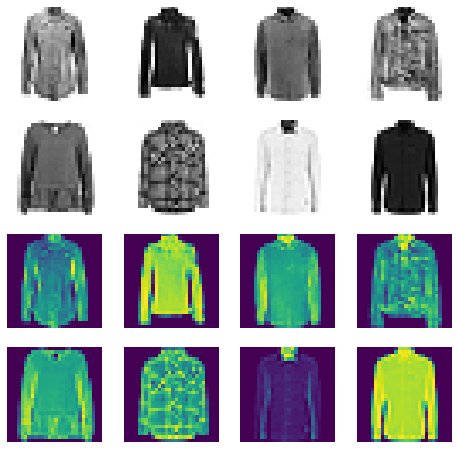

In [ ]:
generate_img(g_model, 'Shirt')

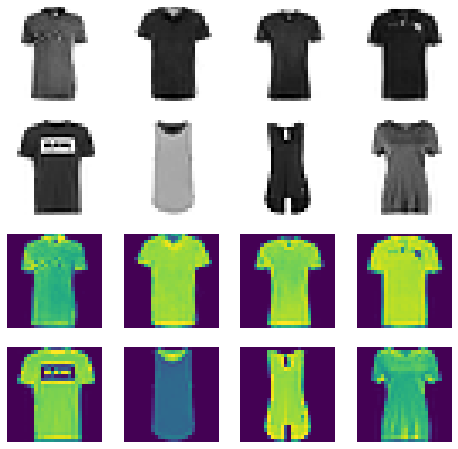

In [ ]:
generate_img(g_model, 'T-shirt/top')

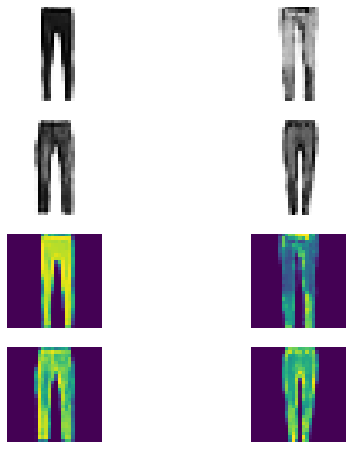

In [ ]:
generate_img(g_model, 'Trouser')

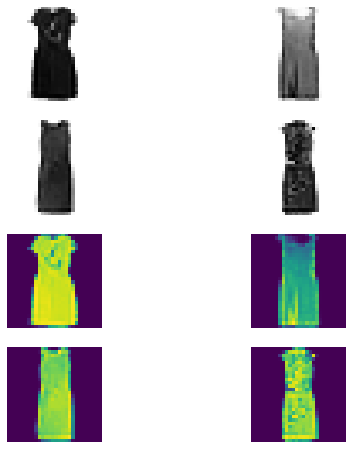

In [ ]:
generate_img(g_model, 'Dress')

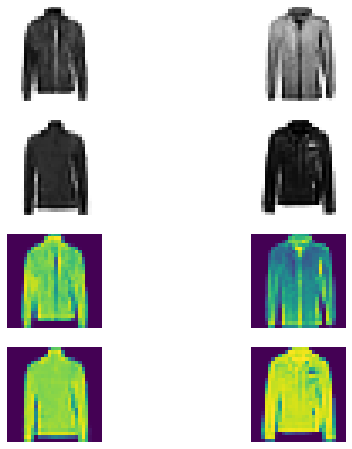

In [ ]:
generate_img(g_model, 'Coat')

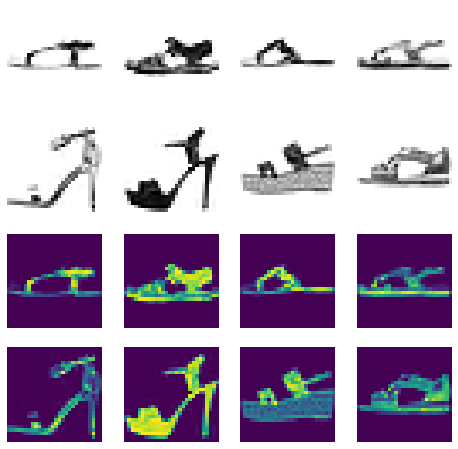

In [ ]:
generate_img(g_model, 'Sandal')

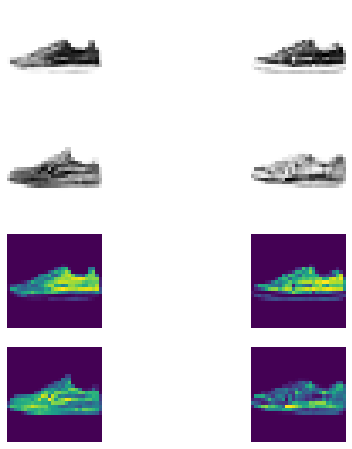

In [ ]:
generate_img(g_model, 'Sneaker')

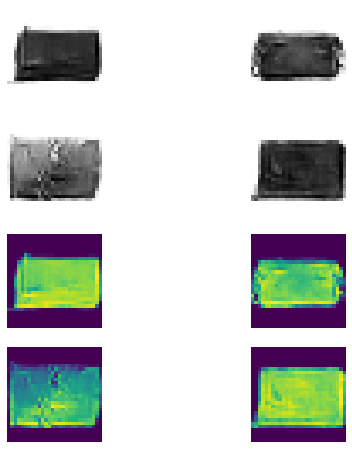

In [ ]:
generate_img(g_model, 'Bag')

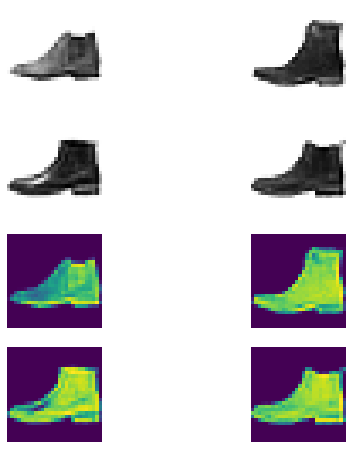

In [ ]:
generate_img(g_model, 'Ankle boot')